In [93]:
 %autosave 0

Autosave disabled


# S12T01 - Pipelines, grid search i text mining
Comencem a familiaritzar-nos amb Pipelines, grid search i text mining !!! Comencem amb uns quants exercicis bàsics

## - Exercici 1.1
Agafa el conjunt de dades que vulguis i realitza un pipeline i un gridsearch aplicant l'algorisme de Random Forest. <br><br>
<font color='blue'>For this activity we'll use a dataset that gathers data of the last years' peformance of the cryptocurrency <b>Ethereum (ETH)</b>. We'll try to predict the performance based on the independent variabless.  Let's start by loading and cleaning the data first:

### - Data import and exploration

In [94]:
import pandas as pd
import matplotlib.pyplot as plt

eth = pd.read_csv(r'ETH.csv')
print("Shape: ", eth.shape, "\n")
print(eth.info(), "\n")
print("NaNs: \n", eth.isna().sum())
eth.set_index('Date', inplace=True)
eth.sample(5)

Shape:  (1598, 7) 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1598 entries, 0 to 1597
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       1598 non-null   object 
 1   Open       1598 non-null   float64
 2   High       1598 non-null   float64
 3   Low        1598 non-null   float64
 4   Close      1598 non-null   float64
 5   Adj Close  1598 non-null   float64
 6   Volume     1598 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 87.5+ KB
None 

NaNs: 
 Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2019-03-01,136.836243,138.995270,136.434784,136.443619,136.443619,3756124824
2020-05-15,202.955399,203.566391,193.755676,195.622665,195.622665,16602342092
2019-12-11,146.320648,147.139206,143.045364,143.608002,143.608002,7037180049
2020-04-29,198.465195,218.454636,198.124512,216.968231,216.968231,26397548759
2021-12-28,4037.538086,4037.538086,3769.280029,3800.893066,3800.893066,17299472803


<font color='blue'>We can try to vizualize the <b>target variable 'Adj Close'</b>, which is the adjusted price which the coin closes the day at, and will set the performance of the criptocurrency:

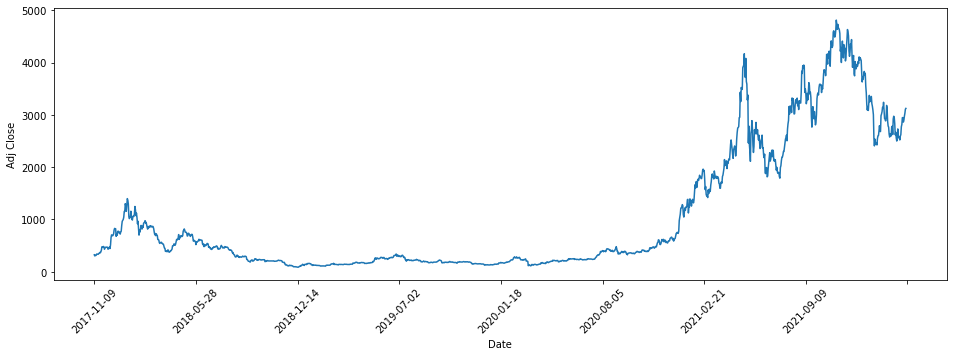

In [95]:
eth['Adj Close'].plot(figsize=(16,5))
plt.ylabel("Adj Close")
plt.xticks(rotation=45)
plt.show()

<font color='blue'>We can see how the line plot shows the trend of the criptocurrency to scale as the times goes by, with some important dips on the road.

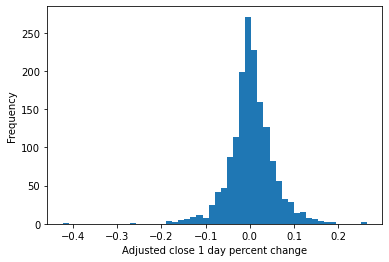

In [96]:
eth['Adj Close'].pct_change().plot.hist(bins=50)
plt.xlabel("Adjusted close 1 day percent change")
plt.show()

<font color='blue'>We can observe the daily price change percentage is mostly concentrated between -20% and +20%, meaning that this cryptocurrency is very volatile. But we can also guess that the average is above 0, confirming the general upper trend of the coin since its inception.
    
### - Train-Test split
    


In [97]:
#part between train and test sets
from sklearn.model_selection import train_test_split 
X=eth.drop(['Adj Close', 'Close'],axis=1)
y=eth['Adj Close']
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3, random_state=30)

<br><font color='blue'>Let's see if we can first apply a pipeline to our data that includes:
   - Scaling
   - Random Forest model training

Let's first figure out if the data follows a normal distribution or not:

In [98]:
# Shapiro-Wilk Normality Test
from scipy.stats import shapiro
stat, p = shapiro(eth)
print('stat=%.3f, p=%.3f' % (stat, p))
if p > 0.05:
	print('Probably Gaussian')
else:
	print('Probably not Gaussian')

stat=0.367, p=0.000
Probably not Gaussian


C:\Users\pacressa\Anaconda3\lib\site-packages\scipy\stats\morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


<font color='blue'>It seems not following a normal distribution, so for the scaler we'll use the <b>MinMaxScaler()</b>.
    
### - GridSearchCV()

In [99]:
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor as RFR
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import MinMaxScaler

#set different hyperparameters options for the model 
param_m = {
    'bootstrap': [True],
    'max_depth': [80, 90, 100, 110],
    'max_features': [2, 3],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [100, 200, 300, 1000]
}

# Create a based model
rf = RFR()

# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_m, cv = 3, n_jobs = -1, verbose = 2)

# Fit the grid search to the data
grid_search.fit(X_train, y_train)

grid_search.best_params_

Fitting 3 folds for each of 288 candidates, totalling 864 fits


{'bootstrap': True,
 'max_depth': 80,
 'max_features': 3,
 'min_samples_leaf': 4,
 'min_samples_split': 8,
 'n_estimators': 100}

<font color='blue'>Now we have the most optimal hyperparameters that we'll use for the model next:

### <font color='blue'>- Pipeline

In [100]:
import numpy as np

#embed scaler and model into the original pipeline
steps = [('scaler', MinMaxScaler()), ('model', RFR())]
pipeline1 = Pipeline(steps)

#designing a secong pipeline with the optimal hyperparameters for the model
steps = [('scaler', MinMaxScaler()), ('model', RFR(bootstrap=True, max_depth=100, max_features=3,
                                        min_samples_leaf=3, min_samples_split=8, n_estimators=200))]
pipeline2 = Pipeline(steps)

#designing a function to assess the performance of any model
def evaluate(model, X_test, y_test):
    predictions = model.predict(X_test)
    errors = abs(predictions - y_test)
    mape = 100 * np.mean(errors / y_test)
    accuracy = 100 - mape
    print('\tAverage Error: {:0.4f} degrees.'.format(np.mean(errors)))
    print('\tAccuracy = {:0.2f}%.'.format(accuracy))
    
    return accuracy

print("PERFORMANCE OF ORIGINAL MODEL:")
model0 = RFR().fit(X_train, y_train)
evaluate(model0, X_test, y_test)

print("\nPERFORMANCE AFTER SCALING & BEFORE HYPERPARAMETER TUNING:")
model1 = pipeline1.fit(X_train, y_train)
evaluate(model1, X_test, y_test)

print("\nPERFORMANCE AFTER SCALING & HYPERPARAMETER TUNING:")
model2 = pipeline2.fit(X_train, y_train)
evaluate(model2, X_test, y_test)
print("")

PERFORMANCE OF ORIGINAL MODEL:
	Average Error: 22.1434 degrees.
	Accuracy = 97.92%.

PERFORMANCE AFTER SCALING & BEFORE HYPERPARAMETER TUNING:
	Average Error: 22.5895 degrees.
	Accuracy = 97.90%.

PERFORMANCE AFTER SCALING & HYPERPARAMETER TUNING:
	Average Error: 22.5264 degrees.
	Accuracy = 97.87%.



<font color='blue'>All the results are very high in accuracy (97%) implying that the model must be over-fitted. However, after passing the model through the Pipeline (scaling data + tuning the model) we can see how the accuracy reduces a bit (0.05%) making the model less under-fitted, hence making it better.

## - Exercici 1.2
Agafa un text en anglès que vulguis, i calcula'n la freqüència de les paraules

<font color='blue'>We'll choose a random Google review of an italian restaurant. This is the selected one:<br><br>
    <b>"Oh my goodness, what can I say? We were totally blown away with this place. The cocktails (Madame Butterfly) and the food (the porchetta was melt in the mouth, the duck ragu savory perfection, in particular) were perfection. I wish I lived closer to visit more often. You need to eat here."
        
### - Tokenization

In [101]:
from nltk.tokenize import word_tokenize

text = "Oh my goodness, what can I say? We were totally blown away with this place. The cocktails (Madame Butterfly) and the food (the porchetta was melt in the mouth, the duck ragu savory perfection, in particular) were perfection. I wish I lived closer to visit more often. You need to eat here."
tokenized_word=word_tokenize(text)
print(tokenized_word)

['Oh', 'my', 'goodness', ',', 'what', 'can', 'I', 'say', '?', 'We', 'were', 'totally', 'blown', 'away', 'with', 'this', 'place', '.', 'The', 'cocktails', '(', 'Madame', 'Butterfly', ')', 'and', 'the', 'food', '(', 'the', 'porchetta', 'was', 'melt', 'in', 'the', 'mouth', ',', 'the', 'duck', 'ragu', 'savory', 'perfection', ',', 'in', 'particular', ')', 'were', 'perfection', '.', 'I', 'wish', 'I', 'lived', 'closer', 'to', 'visit', 'more', 'often', '.', 'You', 'need', 'to', 'eat', 'here', '.']


### <font color='blue'>- Frequency Distribution

<FreqDist with 48 samples and 64 outcomes>
[('.', 4), ('the', 4)]


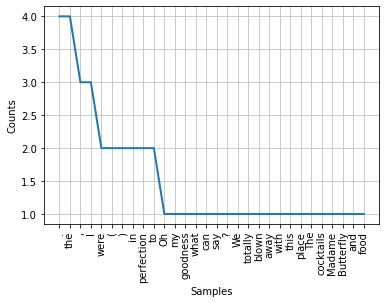

In [102]:
from nltk.probability import FreqDist
fdist = FreqDist(tokenized_word)
print(fdist)

print(fdist.most_common(2))

# Frequency Distribution Plot
import matplotlib.pyplot as plt
fdist.plot(30,cumulative=False)
plt.show()

## - Exercici 2.1
Treu les stopwords i realitza stemming al teu conjunt de dades.<br><br>
### <font color='blue'>- Stopwords

In [103]:
from nltk.corpus import stopwords
stop_words=set(stopwords.words("english"))
print(stop_words)

filtered_sent=[]
for w in tokenized_word:
    if w not in stop_words:
        filtered_sent.append(w)
print("\nTokenized Sentence:",tokenized_word)
print("\nFiltered Sentence:",filtered_sent)

{'his', 'if', 'in', 'both', 'or', 'when', 'yours', 'me', "needn't", 'your', "won't", "hasn't", 'doing', 'very', 'does', 'wouldn', 'why', 'is', 'below', 'each', 'theirs', 'herself', 'this', 'what', 'ourselves', 'most', 's', 'itself', 'up', 'y', 'it', 'until', 'more', 'she', 'again', 'just', 'will', 'between', 'same', 'about', "didn't", 'm', 'yourselves', 'to', 'then', 'than', 'that', 'ours', 'll', "couldn't", "mightn't", 'as', 'there', 'into', 'before', 'did', 'through', 'and', "she's", 'from', 'but', 'have', 'mustn', 'haven', 'such', 'above', "weren't", 'won', "you've", 'himself', 'other', 'hadn', 'while', 'all', "shouldn't", 'mightn', 'of', 'during', 'after', 'should', "shan't", 'they', 'a', 'shouldn', 'couldn', 'whom', 'don', "aren't", 'didn', 'which', 'our', 'its', "it's", 'themselves', 'being', 'ma', 'out', 'not', 'doesn', 'been', 'no', 'do', 'with', 'once', 't', 'was', 're', 'ain', 'wasn', "wasn't", 'off', "doesn't", 'some', 'hasn', 'myself', 'on', "that'll", 'for', "isn't", "don'

### <font color='blue'>- Stemming

In [104]:
# Stemming
from nltk.stem import PorterStemmer
from nltk.tokenize import sent_tokenize, word_tokenize

ps = PorterStemmer()

stemmed_words=[]
for w in filtered_sent:
    stemmed_words.append(ps.stem(w))

print("Filtered Sentence:",filtered_sent)
print("\nStemmed Sentence:",stemmed_words)

Filtered Sentence: ['Oh', 'goodness', ',', 'I', 'say', '?', 'We', 'totally', 'blown', 'away', 'place', '.', 'The', 'cocktails', '(', 'Madame', 'Butterfly', ')', 'food', '(', 'porchetta', 'melt', 'mouth', ',', 'duck', 'ragu', 'savory', 'perfection', ',', 'particular', ')', 'perfection', '.', 'I', 'wish', 'I', 'lived', 'closer', 'visit', 'often', '.', 'You', 'need', 'eat', '.']

Stemmed Sentence: ['oh', 'good', ',', 'i', 'say', '?', 'we', 'total', 'blown', 'away', 'place', '.', 'the', 'cocktail', '(', 'madam', 'butterfli', ')', 'food', '(', 'porchetta', 'melt', 'mouth', ',', 'duck', 'ragu', 'savori', 'perfect', ',', 'particular', ')', 'perfect', '.', 'i', 'wish', 'i', 'live', 'closer', 'visit', 'often', '.', 'you', 'need', 'eat', '.']


## - Exercici 3.1
Realitza sentiment analysis al teu conjunt de dades.

In [115]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer

def sent_analysis(text):
    score = SentimentIntensityAnalyzer().polarity_scores(text)
    print(score)

#analysing sentiment from the original text
sent_analysis(text)

#saving the text in a clear format from the stemmed words before
text_clean = " ".join(stemmed_words)
text_clean

#analysing sentiment from the stemmed text
sent_analysis(text_clean)

{'neg': 0.0, 'neu': 0.775, 'pos': 0.225, 'compound': 0.9201}
{'neg': 0.0, 'neu': 0.667, 'pos': 0.333, 'compound': 0.9186}


<font color='blue'>We've seen the sentiment analysis before and after applying Stemming to the text. In both cases the estimator is quite certain about the result (~92%), but the answer is estimated 70% 'neutral' which is not bringing much information about the text. However it's worth to highlight that the estimator is very certain that the text's sentiment is not 'negative' (0%), while it's 30% probable that's 'positive'. In this case the estimator performs well, since the text is clearly positive.